# Importing Libraries

In [34]:
import numpy as np
import pandas as pd
import datetime as dt
from tabulate import tabulate
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from datetime import timedelta


# Reading Data

In [35]:
read_data = pd.read_csv('TSLV.csv')
read_data = read_data.dropna()
read_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-08-16,45.098000,45.438000,44.681999,44.722000,44.722000,11335500
1,2016-08-17,44.866001,44.966000,44.560001,44.647999,44.647999,8935500
2,2016-08-18,44.764000,45.132000,44.458000,44.702000,44.702000,8572500
3,2016-08-19,44.708000,45.034000,44.506001,45.000000,45.000000,8297500
4,2016-08-22,44.834000,45.021999,44.535999,44.585999,44.585999,10327500


Data Plotting

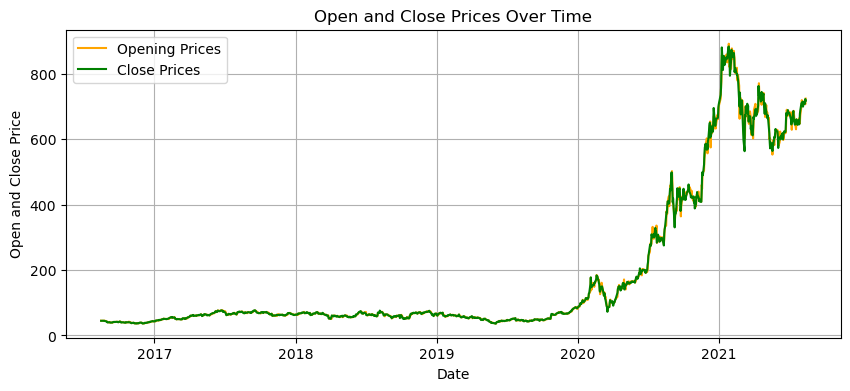

In [36]:
read_data['Date'] = pd.to_datetime(read_data['Date'])
plt.figure(figsize=(10, 4))
plt.plot(read_data['Date'], read_data['Open'], linestyle='-', color='Orange', label='Opening Prices')
plt.plot(read_data['Date'], read_data['Close'], linestyle='-', color='Green', label='Close Prices')
plt.title('Open and Close Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Open and Close Price')
plt.legend()
plt.grid(True)
plt.show()

NULL Values Checking

In [37]:
print("Null values : ", read_data.isnull().values.sum())
print("NA values : ", read_data.isna().values.any())

Null values :  0
NA values :  False


# Detecting Outliers

Using IQR ( Inter Quartile Range) for detecting outliers 

In [38]:
def detect_outliers(column):
    Q1 = read_data[column].quantile(0.25)
    Q3 = read_data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - (1.5 * IQR)
    upper_bound = Q3 + (1.5 * IQR)
    
    outliers= (read_data[column] < lower_bound) | (read_data[column] > upper_bound)
    return outliers 

columns_check = ["Open", "High", "Low","Close", "Adj Close", "Volume"]
outliers = pd.DataFrame()
for column in columns_check:
    outliers[column] = detect_outliers(column)
    

In [39]:
outliers_rows = read_data[outliers.any(axis=1)]
table = tabulate(outliers_rows, headers="keys", tablefmt='pretty')
#print(table)

In [40]:
print("Total rows count in main CSV File : ", len(read_data))
print("Total outliers count : ", len(outliers_rows))

Total rows count in main CSV File :  1258
Total outliers count :  337


# Handling Outliers

Using Quantile flooring and Capping for handling outliers so that the outliers values are replaced by the values based on the percentile value

In [41]:
def quantile_flooring(column, floor_quantile = 0.05, cap_quantile = 0.95):
    floor_value = read_data[column].quantile(floor_quantile)
    cap_value = read_data[column].quantile(cap_quantile)
    
    below_floor = read_data[column] < floor_value
    above_cap = read_data[column] > cap_value
    
    read_data.loc[below_floor, column] = floor_value
    read_data.loc[above_cap, column] = cap_value
    
for i in columns_check:
    quantile_flooring(i)
    
read_data = read_data.round(2)
    
table = tabulate(read_data, headers="keys", tablefmt='pretty')
#print(table)

# SVD

In [42]:
def SVD(A): 
    #step : 1 ===== Calculate A^T * A and A * A^T
    B = np.dot(A.T, A)
    C = np.dot(A, A.T)
    
    #step : 2  ===== EigenValue Decomposition
    B_eigenValue, B_eigenVectors = np.linalg.eig(B)
    C_eigenValue, C_eigenVectors = np.linalg.eig(C)
    
    #Step : 3 ===== Singular Values
    singular_values = np.sqrt(B_eigenValue)
    
    #step : 4 ===== Sort Singular Values
    sorted_value = np.argsort(singular_values)[::-1]
    singular_values = singular_values[sorted_value]
    B_eigenVectors = B_eigenVectors[:, sorted_value]
    
    #step : 5 ===== Construction of Sigma, U, V
    sigma = np.diag(singular_values)
    U, V = np.dot(A, B_eigenVectors) / singular_values, B_eigenVectors
    
    #Step : 6 ===== A reconstruction
    
    A_reconstruct = np.dot(U, np.dot(sigma, V.T))
    
    return A_reconstruct

# Training Data

In [43]:
selected_cells = ["Close"]
A = read_data[selected_cells].values
A_reconstruct = SVD(A)

for i in selected_cells:
    column_values = A_reconstruct[:, selected_cells.index(i)].round(2).tolist()
    table = tabulate(zip(*[column_values[:5]]), headers=[i], tablefmt='pretty')
    print(table)

+-------+
| Close |
+-------+
| 44.72 |
| 44.65 |
| 44.7  |
| 45.0  |
| 44.59 |
+-------+


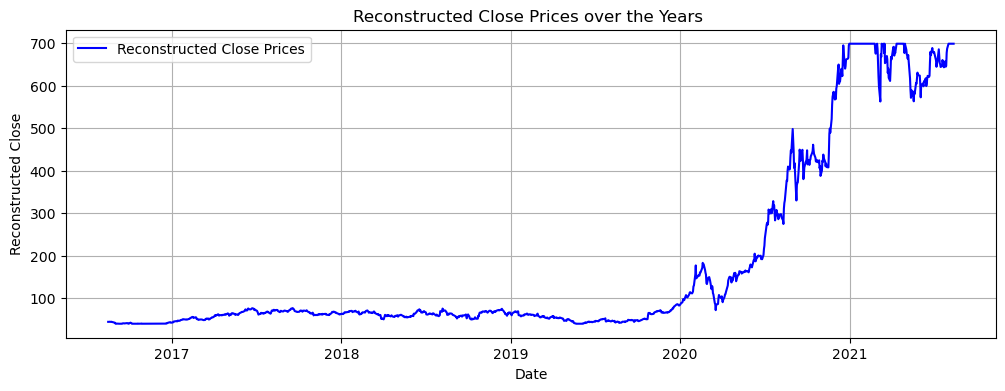

In [44]:
reconstructed_close = A_reconstruct[:, -1]

plt.figure(figsize=(12, 4))
plt.plot(read_data['Date'], reconstructed_close, label='Reconstructed Close Prices', color='Blue')
plt.title('Reconstructed Close Prices over the Years ')
plt.xlabel('Date')
plt.ylabel('Reconstructed Close')
plt.legend()
plt.grid(True)
plt.show()

# Plotting and Evaluation

Reconstruction Error:

Calculate the Frobenius norm of the difference between the original matrix and the reconstructed matrix. The Frobenius norm of a matrix A is defined as the square root of the sum of the absolute squares of its elements.

In [45]:
reconstruction_error = np.linalg.norm(A - A_reconstruct, 'fro')
print("Reconstruction Error:", reconstruction_error)

Reconstruction Error: 5.902638925459806e-13


Explained Variance:

Calculate the ratio of the sum of the squared singular values used in the reconstruction to the total sum of squared singular values.

In [46]:
total_variance = np.sum(np.square(np.linalg.svd(A, compute_uv=False)))
explained_variance = np.sum(np.square(np.linalg.svd(A_reconstruct, compute_uv=False)))
variance_explained_ratio = explained_variance / total_variance
print("Variance Explained Ratio:", variance_explained_ratio)

Variance Explained Ratio: 1.0


Singular Values:

Analyze the singular values to understand their distribution and magnitude.

In [47]:
singular_values = np.linalg.svd(A, compute_uv=False)
print("Singular Values:", singular_values.round(2))


Singular Values: [10011.54]


Rank Selection:

Analyze the singular values to determine an appropriate rank for approximation. You can plot the singular values and look for an "elbow" point, where the rate of decrease slows down.

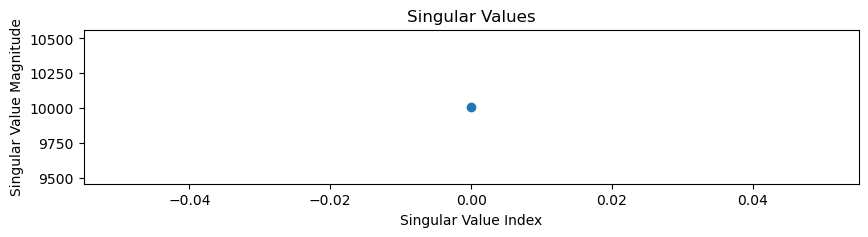

In [48]:
singular_values = np.linalg.svd(A, compute_uv=False)
plt.figure(figsize=(10, 2))
plt.plot(singular_values, marker='o')
plt.title('Singular Values')
plt.xlabel('Singular Value Index')
plt.ylabel('Singular Value Magnitude')
plt.show()

Energy Retained:

Calculate the proportion of energy retained by using a certain number of singular values.

In [49]:
total_energy = np.sum(np.square(singular_values))
retained_energy = np.sum(np.square(np.linalg.svd(A_reconstruct, compute_uv=False)))
energy_retained_ratio = retained_energy / total_energy
print("Energy Retained Ratio:", energy_retained_ratio)

Energy Retained Ratio: 1.0


Cross Validation of Close Values

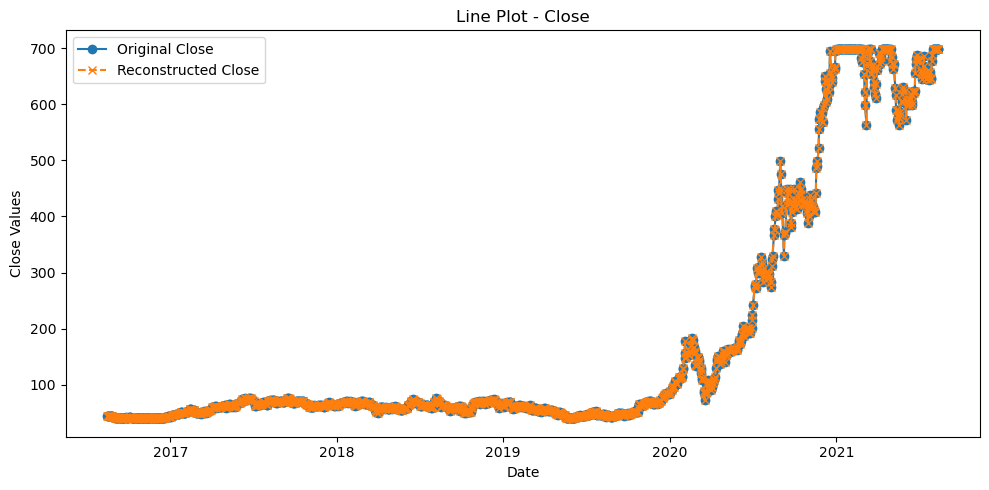

In [50]:
for i in selected_cells:
    fig, ax = plt.subplots(figsize=(10,5))
    ax.plot(read_data['Date'], read_data[i], label=f'Original {i}', linestyle='-', marker='o')
    ax.plot(read_data['Date'], A_reconstruct[:, selected_cells.index(i)], label=f'Reconstructed {i}', linestyle='--', marker='x')
    ax.set_title(f'Line Plot - {i}')
    ax.set_xlabel('Date')
    ax.set_ylabel(f'{i} Values')
    ax.legend()
    plt.tight_layout()
    plt.show()


# Prediction

Last 15 Days Comparison with predicted and original Value

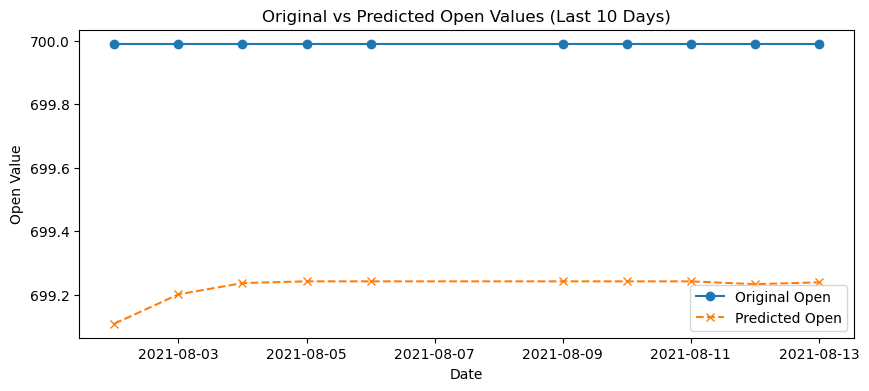

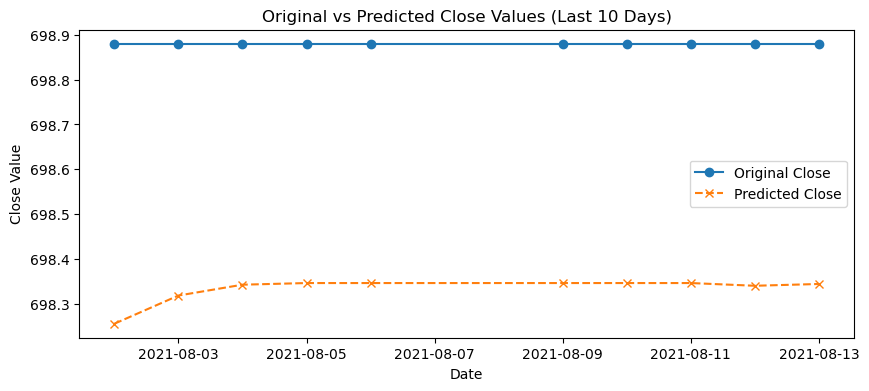

In [58]:
target_columns = ['Open', 'Close']
feature_columns = ['High', 'Low', 'Volume']
X = read_data[feature_columns]
y = read_data[target_columns]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)
last_10_days_features = read_data.iloc[-10:][feature_columns]
predictions = model.predict(last_10_days_features)
predicted_df = pd.DataFrame(predictions, columns=target_columns, index=read_data.iloc[-10:]['Date'])

for column in target_columns:
    plt.figure(figsize=(10, 4))
    plt.plot(read_data.iloc[-10:]['Date'], read_data.iloc[-10:][column], label=f'Original {column}', marker='o')
    plt.plot(predicted_df.index, predicted_df[column], label=f'Predicted {column}', linestyle='--', marker='x')
    plt.title(f'Original vs Predicted {column} Values (Last 10 Days)')
    plt.xlabel('Date')
    plt.ylabel(f'{column} Value')
    plt.legend()
    plt.show()


Custom User_input Prediction

In [ ]:
read_data['Date'] = pd.to_datetime(read_data['Date'])
read_data = read_data.sort_values(by='Date')

X = np.arange(len(read_data)).reshape(-1, 1)

y_open = read_data['Open'].values
y_close = read_data['Close'].values

X_train, X_test, y_open_train, y_open_test, y_close_train, y_close_test = train_test_split(
    X, y_open, y_close, test_size=0.2, shuffle=False
)

model_open = LinearRegression()
model_open.fit(X_train, y_open_train)

model_close = LinearRegression()
model_close.fit(X_train, y_close_train)

last_date = read_data['Date'].iloc[-1]

prediction_days = int(input("Enter Days Count after 14-08-21 : "))
next_dates = [last_date + timedelta(days=i) for i in range(1, prediction_days + 1)]
next_dates_idx = np.arange(len(read_data), len(read_data) + prediction_days).reshape(-1, 1)

open_predictions = model_open.predict(next_dates_idx)
close_predictions = model_close.predict(next_dates_idx)

predictions_df = pd.DataFrame({
    'Date': next_dates,
    'Predicted_Open': open_predictions,
    'Predicted_Close': close_predictions
})

table = tabulate(predictions_df.round(4), headers="keys", tablefmt='pretty')
print(table)
#print(predictions_df.round(4))

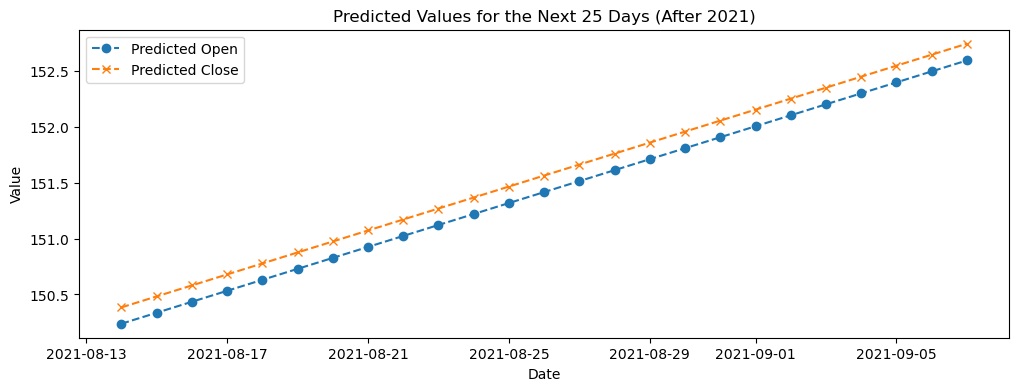

In [66]:
plt.figure(figsize=(12,4))
plt.plot(predictions_df['Date'], predictions_df['Predicted_Open'], label='Predicted Open', linestyle='--', marker='o')
plt.plot(predictions_df['Date'], predictions_df['Predicted_Close'], label='Predicted Close', linestyle='--', marker='x')

plt.title(f'Predicted Values for the Next {prediction_days} Days (After 14-08-2021)')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()